In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import librosa
import math
from datetime import datetime

import audio_functions as af
import model_functions as mf
import audio_models
import dataset
import importlib

Using TensorFlow backend.


In [110]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

In [119]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
    
#checkpoint = '52/52-10' #  Best U-net
checkpoint = '134/134-3'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [120]:
#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()
#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)

voice_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
voice_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
voice_phase = tf.expand_dims(voice_spec[:, :, :-1, 3], 3)

In [121]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag', name='Magnitude_Model')

Creating model


In [113]:
# Build U-Net with magnitude and phase as input and output
mixed_inp = mixed_spec[:, :, :-1, 2:4]
voice_inp = voice_spec[:, :, :-1, 2:4]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag_phase', name='Magnitude_Model')

Creating model


In [30]:
# Build U-Net with real and imaginary as input and output
mixed_inp = mixed_spec[:, :, :-1, 0:2]
voice_inp = voice_spec[:, :, :-1, 0:2]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'real_imag', name='Magnitude_Model')

Creating model


In [122]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

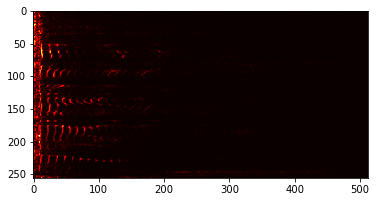

In [44]:
# Test the pipeline still works
m = sess.run(mixed_spec)

plt.imshow(m[0, :, :, 2])

complex_spec = np.empty((m.shape[1], m.shape[2]), dtype=complex)
complex_spec.real = m[0, :, :, 0]
complex_spec.imag = m[0, :, :, 1]

m_wave = librosa.istft(complex_spec.T, fft_hop)
ipd.Audio(m_wave.T, rate=sample_rate)

In [100]:
sess.run(pipe.initializer)

In [125]:
mix_mag, mix_phase, voice_mag, voice_est_mag, \
    mask, voice_wave, mix_wave, cost = sess.run([model.mixed_mag, 
                                                 model.mixed_phase, 
                                                 model.voice_mag,
                                                 model.gen_voice, 
                                                 model.voice_mask, 
                                                 model.voice_audio, 
                                                 model.mixed_audio,
                                                 model.cost],
                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

In [126]:
# For magnitude
for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, 0]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)
    

In [117]:
# For magnitude and phase
for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est_mag[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)
    

In [34]:
# For real and imaginary

complex_spec = np.empty((voice_est_mag.shape[0], voice_est_mag.shape[1], voice_est_mag.shape[2]), dtype=complex)
complex_spec.real = voice_est_mag[:, :, :, 0]
complex_spec.imag = voice_est_mag[:, :, :, 1]

for i in range(complex_spec.shape[0]):
    wave = librosa.istft(complex_spec[i].T, fft_hop)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

In [73]:
voice_est_mag.shape

(5, 256, 512, 2)

In [60]:
mix_mag.shape

(5, 256, 512, 2)

In [92]:
sess.run(mf.l1_loss(voice_est_mag[:, :, :, 0], voice_mag[:, :, :, 0]))

2.433189e-05

In [102]:
mag_loss

2.4012701e-05

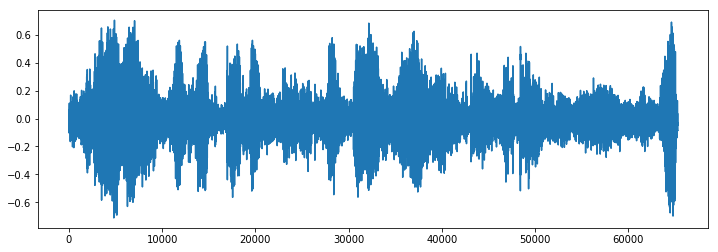

In [62]:
i=2
x = range(len(mix_wave[i]))
plt.figure(figsize=(12,4))
plt.plot(x, mix_wave[i])

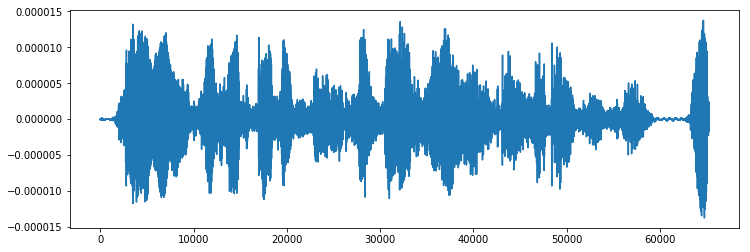

In [118]:
i=2
x = range(len(voice_est_wave[i]))
plt.figure(figsize=(12,4))
plt.plot(x, voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

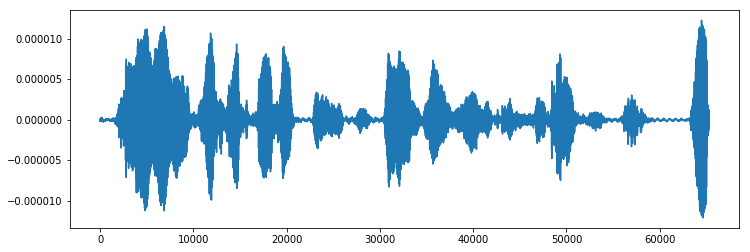

In [127]:
i=2
x = range(len(voice_est_wave[i]))
plt.figure(figsize=(12,4))
plt.plot(x, voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [91]:
def l1(x, y):
    return np.mean(np.abs(x - y))

print(l1(voice_est_mag[0,:,:,0], voice_mag[0,:,:,0]))
print(cost)

4.508612e-05
0.85150206


In [93]:
def phase_loss(x, y):
    
    original_dif = np.abs(x - y)
    add_2_pi_dif = np.abs(x - (y + 2 * math.pi))
    minus_2_pi_dif = np.abs(x - (y - 2 * math.pi))

    corrected_dif = np.minimum(original_dif, np.minimum(add_2_pi_dif, minus_2_pi_dif))

    return np.mean(corrected_dif)

print(phase_loss(voice_est_mag[0,:,:,1], voice_mag[0,:,:,1]))

1.566881


In [50]:
voice_est_mag[0,:,:,1].max()

3.1415927

In [97]:
2 * math.pi

6.283185307179586

In [100]:
voice_mag[0,:,:,0].max()

0.0057107

In [45]:
mag_range = voice_mag[0,:,:,0].max() - voice_mag[0,:,:,0].min()
phase_range = voice_mag[0,:,:,1].max() - voice_mag[0,:,:,1].min()
print(mag_range, '\n', phase_range)

0.0110183 
 0.009891857


In [123]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})


        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                          empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-10-30 16:48:33.956389
Epoch 0 finished. Mean cost = 2.4172826670110226e-05
Epoch 1 finished. Mean cost = 2.413945367152337e-05
Epoch 2 finished. Mean cost = 2.4109507648972794e-05
Epoch 3 finished. Mean cost = 2.4086874873319175e-05
Epoch 4 finished. Mean cost = 2.4069904247880915e-05
Epoch 5 finished. Mean cost = 2.4053899627081893e-05
Epoch 6 finished. Mean cost = 2.4041024257063066e-05
Epoch 7 finished. Mean cost = 2.4027257268244284e-05
Epoch 8 finished. Mean cost = 2.4016121137214617e-05
Epoch 9 finished. Mean cost = 2.400489793217275e-05
Epoch 10 finished. Mean cost = 2.3992867929998532e-05
Epoch 11 finished. Mean cost = 2.3982123821042478e-05
Epoch 12 finished. Mean cost = 2.3971170566465633e-05
Epoch 13 finished. Mean cost = 2.3960307641703237e-05
Epoch 14 finished. Mean cost = 2.3949731985339896e-05
Epoch 15 finished. Mean cost = 2.3937888499858673e-05
Epoch 16 finished. Mean cost = 2.3926298394251397e-05
Epoch 17 finished. Mean cost = 2.391492277335298e-05
Epoch 1

Epoch 152 finished. Mean cost = 2.1296880410826654e-05
Epoch 153 finished. Mean cost = 2.128014428119248e-05
Epoch 154 finished. Mean cost = 2.1262530360892865e-05
Epoch 155 finished. Mean cost = 2.124520869983826e-05
Epoch 156 finished. Mean cost = 2.1227569449811604e-05
Epoch 157 finished. Mean cost = 2.1210053759366216e-05
Epoch 158 finished. Mean cost = 2.1192495977109206e-05
Epoch 159 finished. Mean cost = 2.1174893686293216e-05
Epoch 160 finished. Mean cost = 2.1157033934174048e-05
Epoch 161 finished. Mean cost = 2.1139910502285972e-05
Epoch 162 finished. Mean cost = 2.1123552378524165e-05
Epoch 163 finished. Mean cost = 2.1106624400290015e-05
Epoch 164 finished. Mean cost = 2.1089768525791553e-05
Epoch 165 finished. Mean cost = 2.1072786825769355e-05
Epoch 166 finished. Mean cost = 2.10558218841579e-05
Epoch 167 finished. Mean cost = 2.103847377622428e-05
Epoch 168 finished. Mean cost = 2.102135419843859e-05
Epoch 169 finished. Mean cost = 2.1003487809674184e-05
Epoch 170 finish

Epoch 302 finished. Mean cost = 1.896676582360345e-05
Epoch 303 finished. Mean cost = 1.895500599259417e-05
Epoch 304 finished. Mean cost = 1.894322002819953e-05
Epoch 305 finished. Mean cost = 1.8931554121890156e-05
Epoch 306 finished. Mean cost = 1.8919922484864985e-05
Epoch 307 finished. Mean cost = 1.8908380327473e-05
Epoch 308 finished. Mean cost = 1.8896807145634756e-05
Epoch 309 finished. Mean cost = 1.888538589546149e-05
Epoch 310 finished. Mean cost = 1.8873826769385352e-05
Epoch 311 finished. Mean cost = 1.8862359965145843e-05
Epoch 312 finished. Mean cost = 1.8850881967348784e-05
Epoch 313 finished. Mean cost = 1.8839503204067028e-05
Epoch 314 finished. Mean cost = 1.8828179253475917e-05
Epoch 315 finished. Mean cost = 1.8817146127143524e-05
Epoch 316 finished. Mean cost = 1.8806079295285747e-05
Epoch 317 finished. Mean cost = 1.879509277415715e-05
Epoch 318 finished. Mean cost = 1.8784022179268355e-05
Epoch 319 finished. Mean cost = 1.8773034884134177e-05
Epoch 320 finished

Epoch 453 finished. Mean cost = 1.7594919974109494e-05
Epoch 454 finished. Mean cost = 1.758793925026631e-05
Epoch 455 finished. Mean cost = 1.758099926973955e-05
Epoch 456 finished. Mean cost = 1.7574049036358753e-05
Epoch 457 finished. Mean cost = 1.756721940778354e-05
Epoch 458 finished. Mean cost = 1.7560412543349618e-05
Epoch 459 finished. Mean cost = 1.7553596541367132e-05
Epoch 460 finished. Mean cost = 1.7546778932571616e-05
Epoch 461 finished. Mean cost = 1.753993398987802e-05
Epoch 462 finished. Mean cost = 1.7533133830837444e-05
Epoch 463 finished. Mean cost = 1.7526398076777946e-05
Epoch 464 finished. Mean cost = 1.7519656650757077e-05
Epoch 465 finished. Mean cost = 1.7512954580001763e-05
Epoch 466 finished. Mean cost = 1.7506288482019965e-05
Epoch 467 finished. Mean cost = 1.749955859484808e-05
Epoch 468 finished. Mean cost = 1.7492881689482167e-05
Epoch 469 finished. Mean cost = 1.7486199672891822e-05
Epoch 470 finished. Mean cost = 1.7479585565065183e-05
Epoch 471 finis

Epoch 603 finished. Mean cost = 1.674684712637803e-05
Epoch 604 finished. Mean cost = 1.6742229917710108e-05
Epoch 605 finished. Mean cost = 1.6737636529022453e-05
Epoch 606 finished. Mean cost = 1.673302875019357e-05
Epoch 607 finished. Mean cost = 1.672847197129924e-05
Epoch 608 finished. Mean cost = 1.6723913405468492e-05
Epoch 609 finished. Mean cost = 1.6719407431380995e-05
Epoch 610 finished. Mean cost = 1.67148566177784e-05
Epoch 611 finished. Mean cost = 1.6710320144091004e-05
Epoch 612 finished. Mean cost = 1.670583090598444e-05
Epoch 613 finished. Mean cost = 1.670134022651985e-05
Epoch 614 finished. Mean cost = 1.669687681726835e-05
Epoch 615 finished. Mean cost = 1.669242826281263e-05
Epoch 616 finished. Mean cost = 1.6687976737352726e-05
Epoch 617 finished. Mean cost = 1.6683546111150983e-05
Epoch 618 finished. Mean cost = 1.6679119820917562e-05
Epoch 619 finished. Mean cost = 1.6674676102880885e-05
Epoch 620 finished. Mean cost = 1.6670254976984494e-05
Epoch 621 finished.

Epoch 754 finished. Mean cost = 1.615945605570967e-05
Epoch 755 finished. Mean cost = 1.615614631566767e-05
Epoch 756 finished. Mean cost = 1.615284781298576e-05
Epoch 757 finished. Mean cost = 1.6149562773326076e-05
Epoch 758 finished. Mean cost = 1.6146309324981164e-05
Epoch 759 finished. Mean cost = 1.6143056322298914e-05
Epoch 760 finished. Mean cost = 1.613979996898147e-05
Epoch 761 finished. Mean cost = 1.6136555246688887e-05
Epoch 762 finished. Mean cost = 1.613329818747589e-05
Epoch 763 finished. Mean cost = 1.6130046472554896e-05
Epoch 764 finished. Mean cost = 1.612681779293138e-05
Epoch 765 finished. Mean cost = 1.6123574713301493e-05
Epoch 766 finished. Mean cost = 1.6120339869647157e-05
Epoch 767 finished. Mean cost = 1.6117122405271782e-05
Epoch 768 finished. Mean cost = 1.6113903873250138e-05
Epoch 769 finished. Mean cost = 1.6110696649232157e-05
Epoch 770 finished. Mean cost = 1.6107504825000474e-05
Epoch 771 finished. Mean cost = 1.6104341127829872e-05
Epoch 772 finish

Epoch 904 finished. Mean cost = 1.572886617973708e-05
Epoch 905 finished. Mean cost = 1.572639480129498e-05
Epoch 906 finished. Mean cost = 1.5723893620725694e-05
Epoch 907 finished. Mean cost = 1.5721409091676456e-05
Epoch 908 finished. Mean cost = 1.5718933245887464e-05
Epoch 909 finished. Mean cost = 1.571644501642108e-05
Epoch 910 finished. Mean cost = 1.571396576177499e-05
Epoch 911 finished. Mean cost = 1.5711478844175936e-05
Epoch 912 finished. Mean cost = 1.5708997049621704e-05
Epoch 913 finished. Mean cost = 1.570652903930941e-05
Epoch 914 finished. Mean cost = 1.5704058374278566e-05
Epoch 915 finished. Mean cost = 1.5701599585351953e-05
Epoch 916 finished. Mean cost = 1.569915559027809e-05
Epoch 917 finished. Mean cost = 1.569670676676027e-05
Epoch 918 finished. Mean cost = 1.569426342101311e-05
Epoch 919 finished. Mean cost = 1.569181792013336e-05
Epoch 920 finished. Mean cost = 1.568938689879765e-05
Epoch 921 finished. Mean cost = 1.5686981805826616e-05
Epoch 922 finished. 

In [115]:
# Mag + Phase results, 1000 epochs

start: 2018-10-30 16:40:02.387879
Epoch 0 finished. Mean cost = 1.878292277979199e-05
	Mean magnitude loss = 2.3939534003147855e-05
	Mean phase loss = 1.362631064694142e-05
Epoch 1 finished. Mean cost = 1.8782393453875557e-05
	Mean magnitude loss = 2.3937102014315315e-05
	Mean phase loss = 1.3627684438688448e-05
Epoch 2 finished. Mean cost = 1.878155429343072e-05
	Mean magnitude loss = 2.3933967289243203e-05
	Mean phase loss = 1.3629141600783138e-05
Epoch 3 finished. Mean cost = 1.8780898244585842e-05
	Mean magnitude loss = 2.393078011664329e-05
	Mean phase loss = 1.3631016599902068e-05
Epoch 4 finished. Mean cost = 1.8779786842060275e-05
	Mean magnitude loss = 2.3926747962832452e-05
	Mean phase loss = 1.36328257212881e-05
Epoch 5 finished. Mean cost = 1.8779142313481618e-05
	Mean magnitude loss = 2.392316158269144e-05
	Mean phase loss = 1.3635123044271799e-05
Epoch 6 finished. Mean cost = 1.87786128143281e-05
	Mean magnitude loss = 2.3919810960900838e-05
	Mean phase loss = 1.363741466

Epoch 58 finished. Mean cost = 1.8726926917502246e-05
	Mean magnitude loss = 2.365792241076726e-05
	Mean phase loss = 1.3795931377991742e-05
Epoch 59 finished. Mean cost = 1.87258700862003e-05
	Mean magnitude loss = 2.365272803217522e-05
	Mean phase loss = 1.3799012109908897e-05
Epoch 60 finished. Mean cost = 1.8724856672037516e-05
	Mean magnitude loss = 2.3647623209876282e-05
	Mean phase loss = 1.3802090119288997e-05
Epoch 61 finished. Mean cost = 1.8723730077439422e-05
	Mean magnitude loss = 2.364235622794255e-05
	Mean phase loss = 1.380510391226703e-05
Epoch 62 finished. Mean cost = 1.8722635840753182e-05
	Mean magnitude loss = 2.3637157591154045e-05
	Mean phase loss = 1.3808114061479472e-05
Epoch 63 finished. Mean cost = 1.8721508922681096e-05
	Mean magnitude loss = 2.363188207255007e-05
	Mean phase loss = 1.3811135744390413e-05
Epoch 64 finished. Mean cost = 1.8720396586174433e-05
	Mean magnitude loss = 2.3626647425072196e-05
	Mean phase loss = 1.381414570529999e-05
Epoch 65 finis

Epoch 116 finished. Mean cost = 1.8633175503241662e-05
	Mean magnitude loss = 2.3308783087657535e-05
	Mean phase loss = 1.3957567825544284e-05
Epoch 117 finished. Mean cost = 1.863010698274346e-05
	Mean magnitude loss = 2.3300254138968923e-05
	Mean phase loss = 1.3959959734027014e-05
Epoch 118 finished. Mean cost = 1.8626712035791786e-05
	Mean magnitude loss = 2.329117251829608e-05
	Mean phase loss = 1.3962251461573736e-05
Epoch 119 finished. Mean cost = 1.8623193060799773e-05
	Mean magnitude loss = 2.3281846173025162e-05
	Mean phase loss = 1.3964539842466669e-05
Epoch 120 finished. Mean cost = 1.8619429892552477e-05
	Mean magnitude loss = 2.3272093889964475e-05
	Mean phase loss = 1.3966765782393204e-05
Epoch 121 finished. Mean cost = 1.861552896787275e-05
	Mean magnitude loss = 2.326212624673823e-05
	Mean phase loss = 1.3968931584639024e-05
Epoch 122 finished. Mean cost = 1.8611542922061324e-05
	Mean magnitude loss = 2.3252069821147762e-05
	Mean phase loss = 1.3971015912060895e-05
Epo

Epoch 174 finished. Mean cost = 1.8276595167532963e-05
	Mean magnitude loss = 2.2594968478577876e-05
	Mean phase loss = 1.3958221695377558e-05
Epoch 175 finished. Mean cost = 1.8268708717269792e-05
	Mean magnitude loss = 2.2581292062733898e-05
	Mean phase loss = 1.3956125216778178e-05
Epoch 176 finished. Mean cost = 1.826067945315163e-05
	Mean magnitude loss = 2.2567380240662578e-05
	Mean phase loss = 1.3953978511489043e-05
Epoch 177 finished. Mean cost = 1.825274203031185e-05
	Mean magnitude loss = 2.255371836827691e-05
	Mean phase loss = 1.3951765539061168e-05
Epoch 178 finished. Mean cost = 1.8244671793693584e-05
	Mean magnitude loss = 2.2539834451016855e-05
	Mean phase loss = 1.3949508978860055e-05
Epoch 179 finished. Mean cost = 1.8236649217821348e-05
	Mean magnitude loss = 2.252605930455805e-05
	Mean phase loss = 1.3947238974449445e-05
Epoch 180 finished. Mean cost = 1.8228675090535468e-05
	Mean magnitude loss = 2.2512443997358225e-05
	Mean phase loss = 1.3944906037992564e-05
Epo

Epoch 232 finished. Mean cost = 1.774639978835233e-05
	Mean magnitude loss = 2.1716657433723292e-05
	Mean phase loss = 1.3776142037589284e-05
Epoch 233 finished. Mean cost = 1.7736283871661137e-05
	Mean magnitude loss = 2.170016202406757e-05
	Mean phase loss = 1.3772405610426278e-05
Epoch 234 finished. Mean cost = 1.772621003607476e-05
	Mean magnitude loss = 2.1683712552754863e-05
	Mean phase loss = 1.3768707407159146e-05
Epoch 235 finished. Mean cost = 1.7716131470340275e-05
	Mean magnitude loss = 2.1667293799124556e-05
	Mean phase loss = 1.3764969033649846e-05
Epoch 236 finished. Mean cost = 1.7705962388778208e-05
	Mean magnitude loss = 2.1650667984715472e-05
	Mean phase loss = 1.3761256689227624e-05
Epoch 237 finished. Mean cost = 1.7695772175018248e-05
	Mean magnitude loss = 2.1634038251654946e-05
	Mean phase loss = 1.3757505999024989e-05
Epoch 238 finished. Mean cost = 1.768555141714227e-05
	Mean magnitude loss = 2.161734376245648e-05
	Mean phase loss = 1.3753758972887219e-05
Epoc

Epoch 290 finished. Mean cost = 1.716574705952456e-05
	Mean magnitude loss = 2.075862534015353e-05
	Mean phase loss = 1.357286870701113e-05
Epoch 291 finished. Mean cost = 1.715630837804371e-05
	Mean magnitude loss = 2.0742870892469023e-05
	Mean phase loss = 1.35697457888654e-05
Epoch 292 finished. Mean cost = 1.7146894957173143e-05
	Mean magnitude loss = 2.0727155135238047e-05
	Mean phase loss = 1.3566634701506303e-05
Epoch 293 finished. Mean cost = 1.713752128905201e-05
	Mean magnitude loss = 2.071152845687442e-05
	Mean phase loss = 1.3563514046985133e-05
Epoch 294 finished. Mean cost = 1.712821562003968e-05
	Mean magnitude loss = 2.0695980609901708e-05
	Mean phase loss = 1.356045055618486e-05
Epoch 295 finished. Mean cost = 1.71188825475297e-05
	Mean magnitude loss = 2.068040314313564e-05
	Mean phase loss = 1.3557361878180952e-05
Epoch 296 finished. Mean cost = 1.710960985580185e-05
	Mean magnitude loss = 2.0664925853112676e-05
	Mean phase loss = 1.35542937849965e-05
Epoch 297 finis

Epoch 348 finished. Mean cost = 1.667216196161712e-05
	Mean magnitude loss = 1.9929884484244236e-05
	Mean phase loss = 1.3414439366021952e-05
Epoch 349 finished. Mean cost = 1.6664588978788482e-05
	Mean magnitude loss = 1.9917101620064515e-05
	Mean phase loss = 1.3412076264752873e-05
Epoch 350 finished. Mean cost = 1.66570143095477e-05
	Mean magnitude loss = 1.9904308686186453e-05
	Mean phase loss = 1.3409719862947817e-05
Epoch 351 finished. Mean cost = 1.664946206470962e-05
	Mean magnitude loss = 1.989151970540413e-05
	Mean phase loss = 1.3407404356836526e-05
Epoch 352 finished. Mean cost = 1.6642055147236462e-05
	Mean magnitude loss = 1.9879029938758538e-05
	Mean phase loss = 1.3405080291302577e-05
Epoch 353 finished. Mean cost = 1.6634548514161263e-05
	Mean magnitude loss = 1.9866318418003098e-05
	Mean phase loss = 1.3402778543520384e-05
Epoch 354 finished. Mean cost = 1.662712057738427e-05
	Mean magnitude loss = 1.9853753084890727e-05
	Mean phase loss = 1.3400488005828893e-05
Epoch

Epoch 406 finished. Mean cost = 1.6277145915841357e-05
	Mean magnitude loss = 1.925897512898345e-05
	Mean phase loss = 1.329531665800665e-05
Epoch 407 finished. Mean cost = 1.6271045294660343e-05
	Mean magnitude loss = 1.9248571394361052e-05
	Mean phase loss = 1.329351915037656e-05
Epoch 408 finished. Mean cost = 1.626499213044111e-05
	Mean magnitude loss = 1.9238250283784123e-05
	Mean phase loss = 1.3291733932624028e-05
Epoch 409 finished. Mean cost = 1.6258958666872875e-05
	Mean magnitude loss = 1.9227961103929485e-05
	Mean phase loss = 1.328995618766895e-05
Epoch 410 finished. Mean cost = 1.6252925229254444e-05
	Mean magnitude loss = 1.921765679713277e-05
	Mean phase loss = 1.3288193617118471e-05
Epoch 411 finished. Mean cost = 1.6246930638692557e-05
	Mean magnitude loss = 1.920742190864561e-05
	Mean phase loss = 1.3286439322381765e-05
Epoch 412 finished. Mean cost = 1.6240978453583317e-05
	Mean magnitude loss = 1.9197268706783606e-05
	Mean phase loss = 1.3284688151935363e-05
Epoch 

Epoch 464 finished. Mean cost = 1.595742004835585e-05
	Mean magnitude loss = 1.8711824580555737e-05
	Mean phase loss = 1.3203015477037914e-05
Epoch 465 finished. Mean cost = 1.595243617568813e-05
	Mean magnitude loss = 1.8703253169323827e-05
	Mean phase loss = 1.3201619143018328e-05
Epoch 466 finished. Mean cost = 1.5947471834082013e-05
	Mean magnitude loss = 1.8694738093659512e-05
	Mean phase loss = 1.3200205535553989e-05
Epoch 467 finished. Mean cost = 1.5942537956083797e-05
	Mean magnitude loss = 1.8686260987162983e-05
	Mean phase loss = 1.3198814884193951e-05
Epoch 468 finished. Mean cost = 1.59376064957367e-05
	Mean magnitude loss = 1.867780402016482e-05
	Mean phase loss = 1.3197408930584936e-05
Epoch 469 finished. Mean cost = 1.593267834710361e-05
	Mean magnitude loss = 1.8669363482253987e-05
	Mean phase loss = 1.3195993169381139e-05
Epoch 470 finished. Mean cost = 1.5927775272550955e-05
	Mean magnitude loss = 1.866094317324158e-05
	Mean phase loss = 1.3194607331309614e-05
Epoch 

Epoch 522 finished. Mean cost = 1.5693326192514226e-05
	Mean magnitude loss = 1.8257291307354552e-05
	Mean phase loss = 1.3129361035938002e-05
Epoch 523 finished. Mean cost = 1.568915279447621e-05
	Mean magnitude loss = 1.8250088723600115e-05
	Mean phase loss = 1.3128216825431735e-05
Epoch 524 finished. Mean cost = 1.568501327710692e-05
	Mean magnitude loss = 1.8242952625899177e-05
	Mean phase loss = 1.312707388847013e-05
Epoch 525 finished. Mean cost = 1.568088128104261e-05
	Mean magnitude loss = 1.823581149908123e-05
	Mean phase loss = 1.312595102323521e-05
Epoch 526 finished. Mean cost = 1.5676749736024576e-05
	Mean magnitude loss = 1.822867346403434e-05
	Mean phase loss = 1.3124825970047292e-05
Epoch 527 finished. Mean cost = 1.5672636219609227e-05
	Mean magnitude loss = 1.8221565066293504e-05
	Mean phase loss = 1.3123707335029339e-05
Epoch 528 finished. Mean cost = 1.5668529454289252e-05
	Mean magnitude loss = 1.8214469172010645e-05
	Mean phase loss = 1.3122589700463156e-05
Epoch 

Epoch 580 finished. Mean cost = 1.5470382175207933e-05
	Mean magnitude loss = 1.7871691506681003e-05
	Mean phase loss = 1.3069072817123143e-05
Epoch 581 finished. Mean cost = 1.546683459097333e-05
	Mean magnitude loss = 1.78655492910644e-05
	Mean phase loss = 1.3068119862753557e-05
Epoch 582 finished. Mean cost = 1.5463294655885938e-05
	Mean magnitude loss = 1.7859417284057795e-05
	Mean phase loss = 1.3067171999633629e-05
Epoch 583 finished. Mean cost = 1.5459785027528533e-05
	Mean magnitude loss = 1.7853343479146133e-05
	Mean phase loss = 1.3066226546321211e-05
Epoch 584 finished. Mean cost = 1.5456267162032113e-05
	Mean magnitude loss = 1.784724050423361e-05
	Mean phase loss = 1.3065293788736781e-05
Epoch 585 finished. Mean cost = 1.545275368549644e-05
	Mean magnitude loss = 1.784114453923406e-05
	Mean phase loss = 1.3064362799166007e-05
Epoch 586 finished. Mean cost = 1.544925163143427e-05
	Mean magnitude loss = 1.783507789988995e-05
	Mean phase loss = 1.3063425328891908e-05
Epoch 5

Epoch 638 finished. Mean cost = 1.5279219689591697e-05
	Mean magnitude loss = 1.754002382646813e-05
	Mean phase loss = 1.3018415517132534e-05
Epoch 639 finished. Mean cost = 1.52761626964093e-05
	Mean magnitude loss = 1.7534721860101853e-05
	Mean phase loss = 1.3017603495768527e-05
Epoch 640 finished. Mean cost = 1.527310784912233e-05
	Mean magnitude loss = 1.7529414848448285e-05
	Mean phase loss = 1.3016800811486925e-05
Epoch 641 finished. Mean cost = 1.5270061366750285e-05
	Mean magnitude loss = 1.752411813482762e-05
	Mean phase loss = 1.3016004560423167e-05
Epoch 642 finished. Mean cost = 1.526703096713795e-05
	Mean magnitude loss = 1.7518852268489862e-05
	Mean phase loss = 1.3015209629010205e-05
Epoch 643 finished. Mean cost = 1.526401852569512e-05
	Mean magnitude loss = 1.7513614745851934e-05
	Mean phase loss = 1.301442226740732e-05
Epoch 644 finished. Mean cost = 1.5260997333966806e-05
	Mean magnitude loss = 1.750837201926029e-05
	Mean phase loss = 1.3013622609191383e-05
Epoch 64

Epoch 696 finished. Mean cost = 1.5113417684184747e-05
	Mean magnitude loss = 1.725162895634736e-05
	Mean phase loss = 1.2975206383314986e-05
Epoch 697 finished. Mean cost = 1.5110744782871924e-05
	Mean magnitude loss = 1.7246971386243382e-05
	Mean phase loss = 1.2974518152137446e-05
Epoch 698 finished. Mean cost = 1.5108090935111578e-05
	Mean magnitude loss = 1.72423472294719e-05
	Mean phase loss = 1.2973834613427382e-05
Epoch 699 finished. Mean cost = 1.5105433202344492e-05
	Mean magnitude loss = 1.723772057500485e-05
	Mean phase loss = 1.2973145801100015e-05
Epoch 700 finished. Mean cost = 1.5102791207878732e-05
	Mean magnitude loss = 1.7233119793937488e-05
	Mean phase loss = 1.2972462593276634e-05
Epoch 701 finished. Mean cost = 1.510014968216197e-05
	Mean magnitude loss = 1.7228515353157455e-05
	Mean phase loss = 1.297178398395938e-05
Epoch 702 finished. Mean cost = 1.5097504916647168e-05
	Mean magnitude loss = 1.7223899248427882e-05
	Mean phase loss = 1.2971110557698049e-05
Epoch

Epoch 754 finished. Mean cost = 1.4968020165923501e-05
	Mean magnitude loss = 1.6998241331772524e-05
	Mean phase loss = 1.2937798973572647e-05
Epoch 755 finished. Mean cost = 1.4965668667110746e-05
	Mean magnitude loss = 1.6994137363254262e-05
	Mean phase loss = 1.2937199945703488e-05
Epoch 756 finished. Mean cost = 1.4963325836732332e-05
	Mean magnitude loss = 1.6990055994804942e-05
	Mean phase loss = 1.29365956546308e-05
Epoch 757 finished. Mean cost = 1.4960979403097273e-05
	Mean magnitude loss = 1.6985962127431664e-05
	Mean phase loss = 1.2935996654765659e-05
Epoch 758 finished. Mean cost = 1.4958642663384145e-05
	Mean magnitude loss = 1.698188775788676e-05
	Mean phase loss = 1.2935397544915926e-05
Epoch 759 finished. Mean cost = 1.495631010919552e-05
	Mean magnitude loss = 1.697781752849742e-05
	Mean phase loss = 1.293480266715625e-05
Epoch 760 finished. Mean cost = 1.4953982710014386e-05
	Mean magnitude loss = 1.6973761593507336e-05
	Mean phase loss = 1.2934203805009077e-05
Epoch

Epoch 812 finished. Mean cost = 1.4839271887194516e-05
	Mean magnitude loss = 1.6773543869917594e-05
	Mean phase loss = 1.2904999886572403e-05
Epoch 813 finished. Mean cost = 1.483717613543848e-05
	Mean magnitude loss = 1.6769883238073467e-05
	Mean phase loss = 1.2904469014926447e-05
Epoch 814 finished. Mean cost = 1.483508959201706e-05
	Mean magnitude loss = 1.676623612680498e-05
	Mean phase loss = 1.2903943039374026e-05
Epoch 815 finished. Mean cost = 1.4832996116326161e-05
	Mean magnitude loss = 1.676257788657869e-05
	Mean phase loss = 1.2903414328240401e-05
Epoch 816 finished. Mean cost = 1.4830919072323226e-05
	Mean magnitude loss = 1.675895494248959e-05
	Mean phase loss = 1.290288318434546e-05
Epoch 817 finished. Mean cost = 1.4828840961463067e-05
	Mean magnitude loss = 1.675532362386479e-05
	Mean phase loss = 1.2902358281271717e-05
Epoch 818 finished. Mean cost = 1.4826767532239778e-05
	Mean magnitude loss = 1.6751694552162866e-05
	Mean phase loss = 1.2901840495659276e-05
Epoch 

Epoch 870 finished. Mean cost = 1.4724256529065581e-05
	Mean magnitude loss = 1.6572553490925564e-05
	Mean phase loss = 1.2875959563028815e-05
Epoch 871 finished. Mean cost = 1.4722374051024242e-05
	Mean magnitude loss = 1.6569264080901305e-05
	Mean phase loss = 1.2875484018018183e-05
Epoch 872 finished. Mean cost = 1.4720501957279813e-05
	Mean magnitude loss = 1.656598928372648e-05
	Mean phase loss = 1.2875014626665933e-05
Epoch 873 finished. Mean cost = 1.471862649276246e-05
	Mean magnitude loss = 1.656270761992404e-05
	Mean phase loss = 1.2874545360397821e-05
Epoch 874 finished. Mean cost = 1.471675845615599e-05
	Mean magnitude loss = 1.6559442687139382e-05
	Mean phase loss = 1.2874074221014909e-05
Epoch 875 finished. Mean cost = 1.4714900992794978e-05
	Mean magnitude loss = 1.6556189202632903e-05
	Mean phase loss = 1.2873612779842346e-05
Epoch 876 finished. Mean cost = 1.471303705885634e-05
	Mean magnitude loss = 1.6552933793863882e-05
	Mean phase loss = 1.287314032073764e-05
Epoch

Epoch 928 finished. Mean cost = 1.4620825625171978e-05
	Mean magnitude loss = 1.6391682083408895e-05
	Mean phase loss = 1.2849969165956058e-05
Epoch 929 finished. Mean cost = 1.4619134829748266e-05
	Mean magnitude loss = 1.6388725093112112e-05
	Mean phase loss = 1.2849544564428519e-05
Epoch 930 finished. Mean cost = 1.4617439847423646e-05
	Mean magnitude loss = 1.6385759975479266e-05
	Mean phase loss = 1.2849119716437327e-05
Epoch 931 finished. Mean cost = 1.4615751283580303e-05
	Mean magnitude loss = 1.6382805476453348e-05
	Mean phase loss = 1.28486970877797e-05
Epoch 932 finished. Mean cost = 1.4614068036519341e-05
	Mean magnitude loss = 1.6379860899997148e-05
	Mean phase loss = 1.2848275170117115e-05
Epoch 933 finished. Mean cost = 1.461238928093996e-05
	Mean magnitude loss = 1.6376919573175358e-05
	Mean phase loss = 1.2847858986757037e-05
Epoch 934 finished. Mean cost = 1.4610709454999667e-05
	Mean magnitude loss = 1.6373982955343687e-05
	Mean phase loss = 1.2847435953682924e-05
Ep

Epoch 986 finished. Mean cost = 1.4527317371922135e-05
	Mean magnitude loss = 1.6228086823564703e-05
	Mean phase loss = 1.2826547914750724e-05
Epoch 987 finished. Mean cost = 1.452578294723611e-05
	Mean magnitude loss = 1.6225401103974763e-05
	Mean phase loss = 1.2826164784053668e-05
Epoch 988 finished. Mean cost = 1.4524248991768027e-05
	Mean magnitude loss = 1.6222714889597482e-05
	Mean phase loss = 1.282578308842091e-05
Epoch 989 finished. Mean cost = 1.4522716946425998e-05
	Mean magnitude loss = 1.622003702883523e-05
	Mean phase loss = 1.2825396857585999e-05
Epoch 990 finished. Mean cost = 1.4521187285413202e-05
	Mean magnitude loss = 1.6217363964880272e-05
	Mean phase loss = 1.282501059952185e-05
Epoch 991 finished. Mean cost = 1.4519663057311142e-05
	Mean magnitude loss = 1.6214703008692537e-05
	Mean phase loss = 1.2824623099511942e-05
Epoch 992 finished. Mean cost = 1.4518138562509188e-05
	Mean magnitude loss = 1.6212040255959255e-05
	Mean phase loss = 1.2824236863563686e-05
Epo